In [1]:
from galore_torch import HMTAdamW, Lotus, GaLoreAdamW, ApolloAdamW
from tqdm import tqdm
import numpy as np
import time
from typing import Callable, Iterable, Tuple
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

d:\Anaconda\envs\mel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda\envs\mel\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512, bias=False)
        self.linear2 = nn.Linear(512, 1024, bias=False)
        self.linear3 = nn.Linear(1024, 512, bias=False)
        self.linear4 = nn.Linear(512, output_dim, bias=False)
        self.relu = nn.ReLU()
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)                         
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)                         
        x = self.linear4(x)                       
        x = self.out_act(x)
        return x



In [3]:
def benchmark(optimizer_name):
    m, n = 4096, 256
    input_dim = n
    output_dim = 1

    X = torch.randn(1, m, n)
    y = torch.randn(1, m, output_dim)

    model = SimpleNN(input_dim, output_dim).cuda()  
    
    criterion = nn.MSELoss()

    non_lowrank_params = []
    lowrank_params = []

    for name, param in model.named_parameters():
        if "linear" in name and param.requires_grad:
            lowrank_params.append(param)
        elif param.requires_grad:
            non_lowrank_params.append(param)

    param_groups = [
    {'params': non_lowrank_params}, 
    {
        'params': lowrank_params, 
        "rank": 32,
        "update_proj_gap": 50,
        "scale": 1.0,
        "proj_type": "std",
        "proj" : "random",
        "scale_type": "channel"}             
                ]


    if optimizer_name == "Galore":
        optimizer = GaLoreAdamW(param_groups, lr = 1e-4, weight_decay = 0.005)
    elif optimizer_name == "HMT":
        optimizer = HMTAdamW(param_groups, lr = 1e-4, weight_decay = 0.005)
    elif optimizer_name == "Apollo":
        optimizer = ApolloAdamW(param_groups, lr = 1e-4, weight_decay = 0.005)
    elif optimizer_name == "Lotus":
        optimizer = Lotus(param_groups, lr = 1e-4, weight_decay = 0.005)
    else:
        return ValueError("Wrong Name")
    
    errors = []

    total_time = 0
    start_time = time.time()

    for i in tqdm(range(1200)):
        model.train()
        output = model(X.cuda())  
        loss = criterion(output, y.cuda()) 

        optimizer.zero_grad()
        loss.backward(retain_graph=False) 
        optimizer.step()
    
        model.eval()
        with torch.no_grad():
            output = model(X.cuda())
            loss = criterion(output, y.cuda())
            errors.append(loss.item())
            
    total_time = time.time() - start_time
    print(f"Total Time for {optimizer_name}: {total_time:.4f} seconds")

    plt.figure(figsize=(12, 6))
    
    plt.plot(errors, label=f'{optimizer_name} Errors', color='blue')
    
    plt.title('Loss over Training Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

d:\MyDesktop\EMNLP\Lotus\galore_torch\adamw.py:49: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1200/1200 [00:18<00:00, 64.67it/s]

Total Time for Galore: 18.5779 seconds


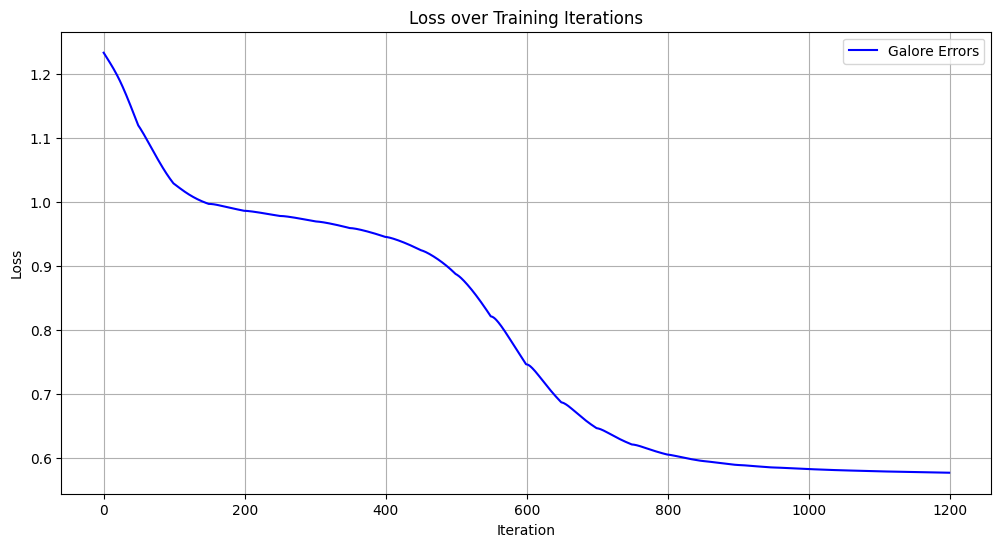

In [4]:
benchmark("Galore")

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:19<00:00, 61.14it/s]

Total Time for Apollo: 19.6340 seconds


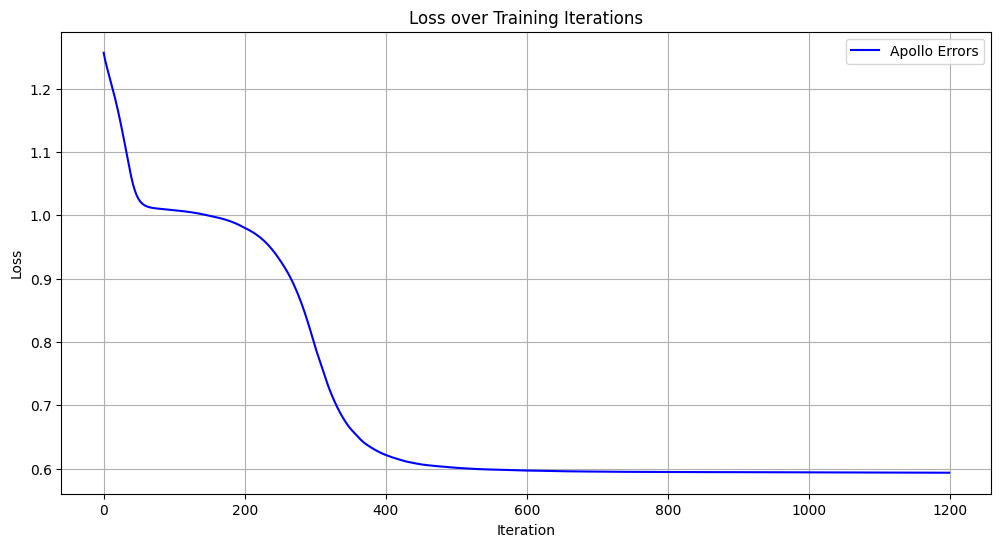

In [5]:
benchmark("Apollo")

d:\MyDesktop\EMNLP\Lotus\galore_torch\HMTadamw.py:49: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1200/1200 [00:21<00:00, 55.38it/s]


Total Time for HMT: 21.6755 seconds


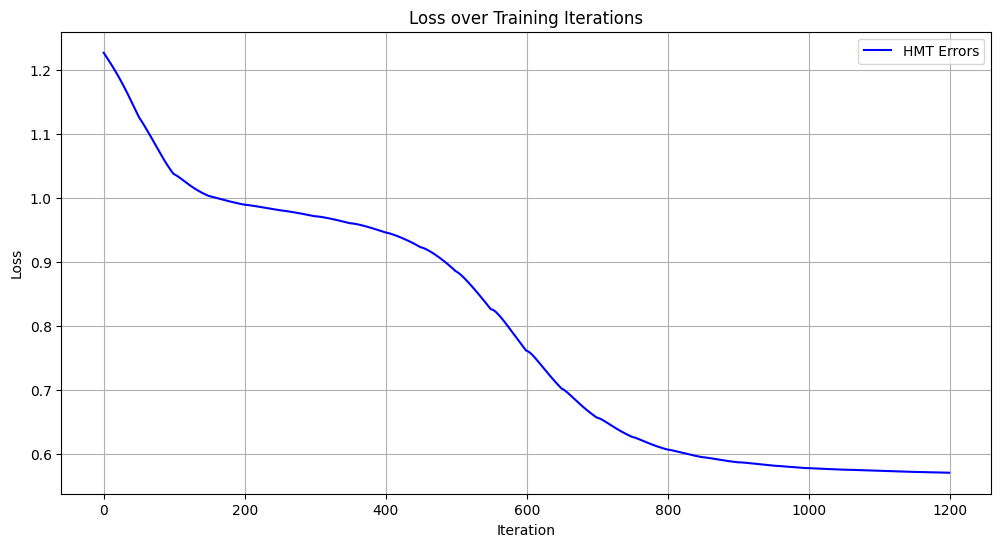

In [6]:
benchmark("HMT")

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:23<00:00, 51.81it/s]


Total Time for Lotus: 23.1699 seconds


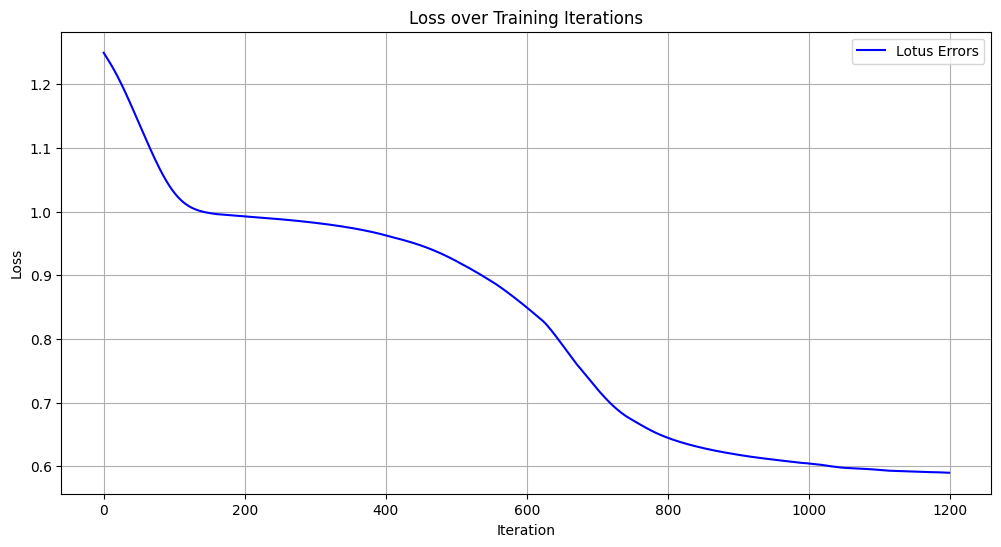

In [7]:
benchmark("Lotus")